# Importing the needed Libraries & Directories

Importing the required libraries and directories are important to avoid errors for it also allows the codes to work perfectly.

In [2]:
import pandas as pd
import numpy as np
import cv2
import json
import os
import matplotlib.pyplot as plt
import random
import seaborn as sns
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/annotations"
image_directory = "./face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images"
df = pd.read_csv("./face-mask-detection-dataset/train.csv")
df_test = pd.read_csv("./face-mask-detection-dataset/submission.csv")

2023-05-21 02:38:49.043534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Importing SSD pretrained weights (Caffe Face Detector Model)

SSD or Single Shot Multibox Detector is used for detecting specific object in a given image. This SSD that I'm going to use is already pre-trained, which means although it has aquired some knowledge about its task, it still need to be trained (which I'll do later in the last lines of code for this project). 

In [3]:
cvNet = cv2.dnn.readNetFromCaffe('./caffe-face-detector-opencv-pretrained-model/architecture.txt','./caffe-face-detector-opencv-pretrained-model/weights.caffemodel')

# Functions to be used

The lines of code below is the JSON Function. This function retrieves the json file from the training dataset which contains the bounding box data.

In [4]:
def getJSON(filePathandName):
    with open(filePathandName,'r') as f:
        return json.load(f)

Next function is the Gamma correction. When applied, the images will get extra bright. For instance,  gamma < 1 will cause the image to get darker, and gamma > 1 will cause the image to be brighter.

In [5]:
def adjust_gamma(image, gamma=1.0):
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)])
    return cv2.LUT(image.astype(np.uint8), table.astype(np.uint8))

# Pre-processing the Data

Data pre-processing is used for converting a raw data into a clean dataset.
Lets look at the JSON data given for training:

The Annotations Field contains all the information about the faces shown in a given image. There are different classnames but the only true classnames are face_with_mask and face_no_mask.

In [6]:
jsonfiles= []
for i in os.listdir(directory):
    jsonfiles.append(getJSON(os.path.join(directory,i)))
jsonfiles[0]

{'FileName': '2310.png',
 'NumOfAnno': 3,
 'Annotations': [{'isProtected': False,
   'ID': 81768340414106304,
   'BoundingBox': [213, 169, 325, 299],
   'classname': 'face_other_covering',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 613664631614999424,
   'BoundingBox': [171, 168, 346, 299],
   'classname': 'hijab_niqab',
   'Confidence': 1,
   'Attributes': {}},
  {'isProtected': False,
   'ID': 166231871773593440,
   'BoundingBox': [435, 183, 470, 223],
   'classname': 'face_no_mask',
   'Confidence': 1,
   'Attributes': {}}]}

In [7]:
df = pd.read_csv("./face-mask-detection-dataset/train.csv")
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


The mask label and non-mask label are utilized to extract bounding box information from json files. The very purpose of the Training Process is to extract and save the label and the faces of the given image into the data list.

In [8]:
data = []
img_size = 124
mask = ['face_with_mask']
non_mask = ["face_no_mask"]
labels={'mask':0,'without mask':1}
for i in df["name"].unique():
    f = i+".json"
    for j in getJSON(os.path.join(directory,f)).get("Annotations"):
        if j["classname"] in mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))
            data.append([img,labels["mask"]])
        if j["classname"] in non_mask:
            x,y,w,h = j["BoundingBox"]
            img = cv2.imread(os.path.join(image_directory,i),1)
            img = img[y:h,x:w]
            img = cv2.resize(img,(img_size,img_size))    
            data.append([img,labels["without mask"]])
random.shuffle(data)    

Checking how many objects are available in the given data.

In [9]:
len(data)

5749

Base on the visualization below, the Number of Mask images is greater than the Number of Non-Mask images which means its an imbalanced dataset.

<AxesSubplot:ylabel='count'>

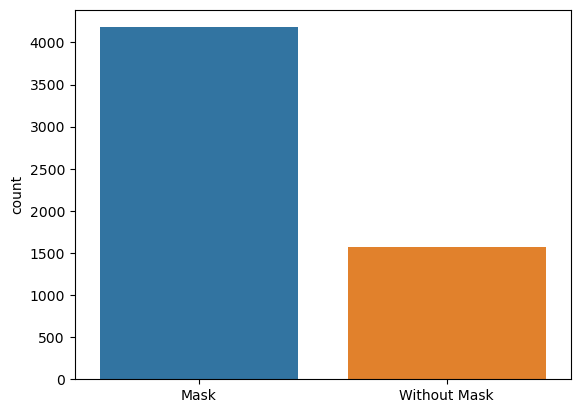

In [10]:
p = []
for face in data:
    if(face[1] == 0):
        p.append('Mask')
    else:
        p.append('Without Mask')


sns.countplot(x=p)

The lines of code below is used for getting the shape of the features in the face mask data.

In [11]:
X = []
Y = []
for features,label in data:
    X.append(features)
    Y.append(label)


In [12]:
X[0].shape

(124, 124, 3)

The lines of code below is used for getting the labels in the face mask data.

In [13]:
X = np.array(X)/255.0
X = X.reshape(-1,124,124,3)
Y = np.array(Y)

In [14]:
np.unique(Y)

array([0, 1])

In [15]:
Y.shape

(5749,)

# Understanding the Model's Architecture and Training Process

The project's model architecture is only a rough abstraction. To start the training process we have to set the model to sequential first, after that we can start adding the needed attributes to the model.

In [16]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(124,124,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

2023-05-21 02:40:12.652199: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-21 02:40:12.656737: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


The line code below summarizes the model

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 122, 122, 64)      18496     
                                                                 
 conv2d_2 (Conv2D)           (None, 120, 120, 128)     73856     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 60, 60, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 60, 60, 128)       0         
                                                                 
 flatten (Flatten)           (None, 460800)            0         
                                                        

The line code below is for compiling the model by setting the loss to binary cross entropy, the optimizer to adam, and lastly, the metrics to accuracy.

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam' ,metrics=['accuracy'])

Next, to get the xtrain, xval, ytrain, and yval, we have to use the train_test_split.

In [19]:
xtrain,xval,ytrain,yval=train_test_split(X, Y,train_size=0.8,random_state=0)

xtrain.shape

(4599, 124, 124, 3)

Now, to generate the image data we have to use the image data generator. This is also to fit the xtrain to the data generation variable.

In [20]:
datagen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False,  
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,    
        rotation_range=15,    
        width_shift_range=0.1,
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=False)
datagen.fit(xtrain)

Now for the history variable, we have to store here the generated fit model along with 50 epochs which may take a while to load.

In [21]:
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=32),
                    steps_per_epoch=xtrain.shape[0]//32,
                    epochs=50,
                    verbose=1,
                    validation_data=(xval, yval))

Epoch 1/50


/home/saraiva/anaconda3/envs/daa/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


143/143 [==============================] - 451s 3s/step - loss: 0.5506 - accuracy: 0.7276 - val_loss: 0.3329 - val_accuracy: 0.7174
Epoch 2/50
 13/143 [=>............................] - ETA: 7:46 - loss: 0.3030 - accuracy: 0.7620

: 

: 

# Creating Visualisations for Training and Validation

The lines of code below creates a graph that differentiates the accuracy of training and validation of all the epochs that were created in the history variable.

In [ ]:
plt.plot(history['accuracy'],'g')
plt.plot(history['val_accuracy'],'b')
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

Next, the lines of code below creates a graph that differentiates all the epochs' training and validation loss that were also created in the history variable.

In [ ]:
plt.plot(history.history['loss'],'g')
plt.plot(history.history['val_loss'],'b')
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Face Mask Detector Model Testing

Now for testing the Face Mask Detector Model, we'll have to use a few images from the dataset to be able to evaluate the model.

In [ ]:
print(len(df_test["name"]),len(df_test["name"].unique()))

8142 1698


test_images array is consisted of image names to be use for testing the model.

In [ ]:
test_images = ['1114.png','1504.jpg', '0072.jpg','0012.jpg','0353.jpg','1374.jpg']

Now, for presenting the results we have to set the gamma = 2, and then set the presentation size to 3 rows and 2 columns.

1/1 [==============================] - 0s 80ms/step


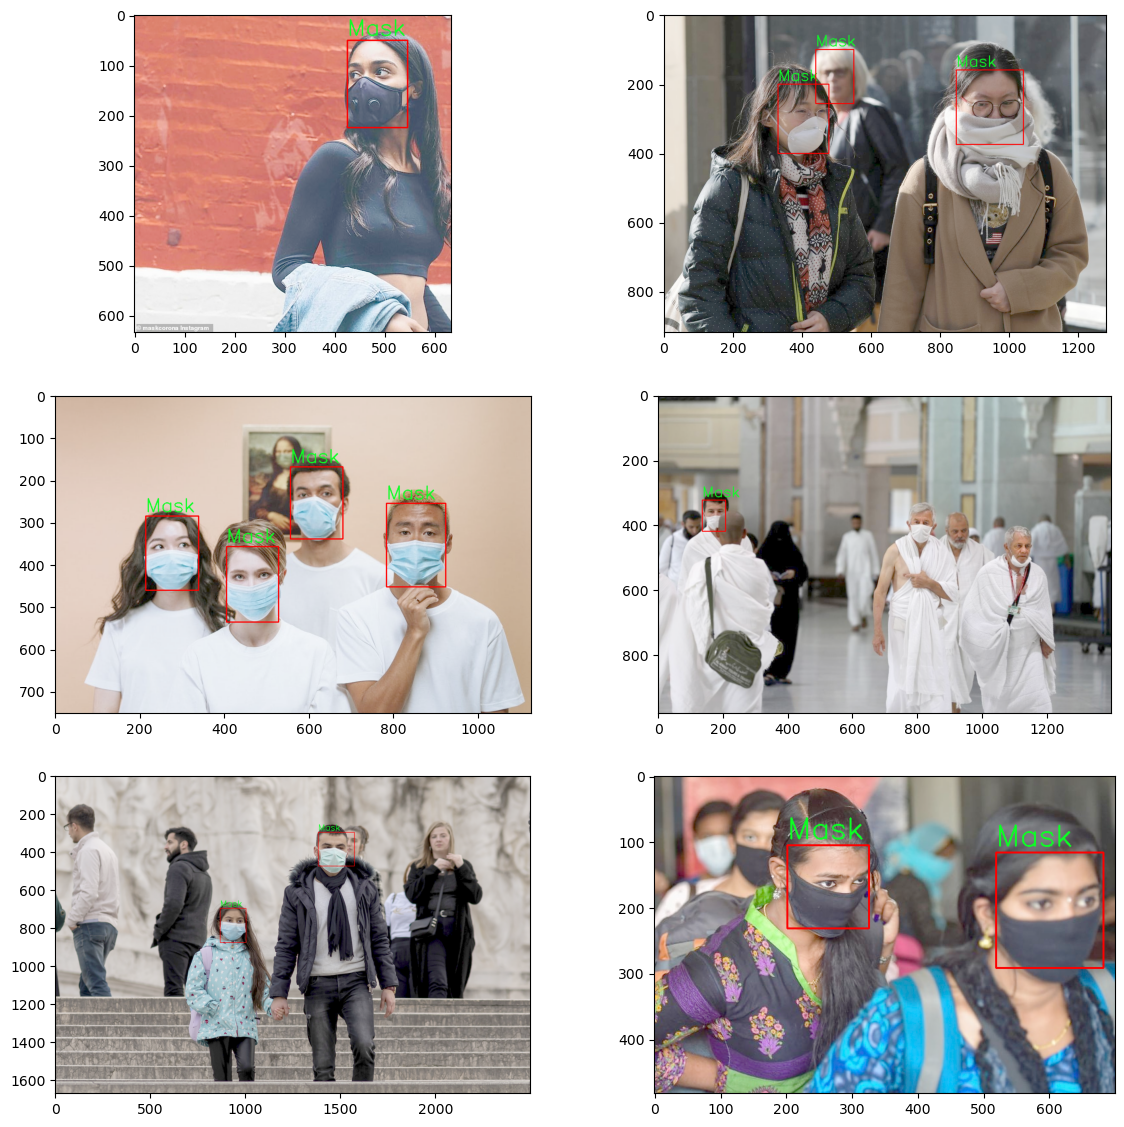

In [ ]:
gamma = 2.0
fig = plt.figure(figsize = (14,14))
rows = 3
cols = 2
axes = []
assign = {'0':'Mask','1':"No Mask"}
for j,im in enumerate(test_images):
    image =  cv2.imread(os.path.join(image_directory,im),1)
    image =  adjust_gamma(image, gamma=gamma)
    (h, w) = image.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(image, (300,300)), 1.0, (300, 300), (104.0, 177.0, 123.0))
    cvNet.setInput(blob)
    detections = cvNet.forward()
    for i in range(0, detections.shape[2]):
        try:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            frame = image[startY:endY, startX:endX]
            confidence = detections[0, 0, i, 2]
            if confidence > 0.2:
                im = cv2.resize(frame,(img_size,img_size))
                im = np.array(im)/255.0
                im = im.reshape(1,124,124,3)
                result = model.predict(im)
                if result>0.5:
                    label_Y = 1
                else:
                    label_Y = 0
                cv2.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)
                cv2.putText(image,assign[str(label_Y)] , (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (36,255,12), 2)
        
        except:pass
    axes.append(fig.add_subplot(rows, cols, j+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

# Conclusion

Looking at the results, we can see that the whole system performs well when faces have spatial dominance, such as shown in the images at (1,1), (1,2), and (2,1). But it can also be seen that the model fails to detect small faces and take up less space in the overall image which can be seen in (2,2). For better results, you can use 3 different methods such as using the different image preprocessing techniques, or keep the confidence threshold low, or by trying different blob sizes. 